# 🤖 Student Success Modeling Scaffold
This notebook will guide you through building both a classification and regression model using the cleaned dataset.

**Classification Goal**: Predict if a student will pass or fail.
**Regression Goal**: Predict the student’s final numeric score.

## 📥 Step 1: Load Blended Dataset

In [1]:
# TODO: Load the merged CSV file
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('student_success_blended_lowercase.csv')
# Optional: Check the column names and preview data
# df.head()

## 🧹 Step 2: Prepare Features and Targets

In [2]:
# TODO: Choose predictors and prepare targets for classification and regression

# Changing from string to int values
df_full = df.copy()

# Создаём бинарный таргет заранее
df_full["final_result_clean"] = df_full["final_result"].str.strip().str.lower()
df_full["target_pass"] = df_full["final_result_clean"].apply(lambda x: 1 if x == "pass" else 0)
df_full = df_full.drop(columns=["final_result","final_result_clean"])

# Cols which can cause leaking for Classification
remove_cols_clf = [
    "final_result",       # Classification target
    "target_pass",        # Classification target
    
]
# Cols which can cause leaking for Regression
remove_cols_reg = [
    "avg_assessment_score" # Regression target
]

# Categorical cols if we would like to use some of them
categorical_cols = [
    'gender',
    'region',
    'highest_education',
    'imd_band',
    'age_band',
    'disability',
    'module',
    'presentation'
]

# Numeric features
numeric_features = [
    'assessments_attempted',
    "avg_assessment_score",
    'total_clicks',
    'active_days',
    'studied_credits',
    'num_of_prev_attempts'
]

combined = numeric_features + categorical_cols

# One-hot encoding for Categorical
df_encoded = pd.get_dummies(df_full, columns=categorical_cols, drop_first=True)

# Classification
X_clf = df_full[numeric_features] # only numerical features
y_clf = df_full["target_pass"] 

#Regression
X_reg = df_encoded.drop(columns=["avg_assessment_score"])
y_reg = df_full["avg_assessment_score"]


X_reg.head(10)
# TODO: Select relevant numeric features
# Example: avg_assessment_score, total_clicks, assessments_attempted
# For classification, you may predict final_result_cleaned
# For regression, you may use avg_assessment_score as proxy for score

,student_id,num_of_prev_attempts,studied_credits,assessments_attempted,total_clicks,active_days,target_pass,gender_M,region_East Midlands Region,region_Ireland,...,disability_Y,module_BBB,module_CCC,module_DDD,module_EEE,module_FFF,module_GGG,presentation_2013J,presentation_2014B,presentation_2014J
0,11391,0,240,5.0,934.0,40.0,1,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,28400,0,60,5.0,1435.0,80.0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,31604,0,60,5.0,2158.0,123.0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,32885,0,60,5.0,1034.0,70.0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,38053,0,60,5.0,2445.0,143.0,1,True,False,False,...,False,False,False,False,False,False,False,True,False,False
5,45462,0,60,5.0,1492.0,90.0,1,True,False,False,...,False,False,False,False,False,False,False,True,False,False
6,45642,0,120,5.0,1428.0,105.0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7,52130,0,90,5.0,1894.0,122.0,1,False,False,False,...,False,False,False,False,False,False,False,True,False,False
8,53025,0,60,5.0,3158.0,142.0,1,True,False,False,...,False,False,False,False,False,False,False,True,False,False
9,57506,0,60,5.0,1319.0,90.0,1,True,False,False,...,False,False,False,False,False,False,False,True,False,False


## 🔍 Step 3: Train Logistic Regression (Classification)

In [3]:
# TODO: Train a logistic regression model and evaluate with accuracy, classification report, and ROC curve
# Hint: Use train_test_split, LogisticRegression, classification_report, roc_auc_score
def train_model(model_type, X, y):
    """
    model_type: 'RF' for RandomForest, 'LR' for Logistic Regression
    """

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Choose model Logistic Regression or RandomForest
    if model_type == "RF":
        model = RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            random_state=42
        )
    elif model_type == "LR":
        model = LogisticRegression(
            max_iter=10000
        )
    else:
        raise ValueError("model_type must be 'RF' or 'LR'")

    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    # Return everything
    return {
        "model": model,
        "accuracy": accuracy,
        "auc": auc,
        "report": report,
        "y_test": y_test,
        "y_prob": y_prob,
    }

Accuracy: 0.7050834303453628
ROC AUC: 0.7773847056678457


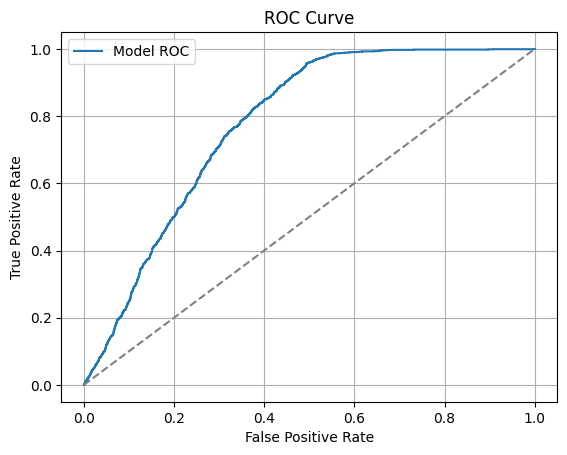

In [4]:
result_lr = train_model("LR", X_clf, y_clf)

y_test_lr = result_lr["y_test"]
y_prob_lr = result_lr["y_prob"]
accuracy_lr = result_lr["accuracy"]
auc_lr = result_lr["auc"]

fpr, tpr, _ = roc_curve(y_test_lr, y_prob_lr)


print("Accuracy:", accuracy_lr)
print("ROC AUC:", auc_lr)

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.legend()
plt.show()

Accuracy: 0.7871556072953046
ROC AUC: 0.8719236128636512


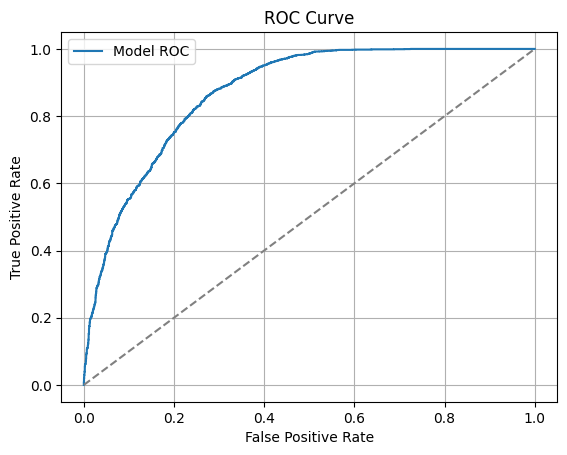

In [5]:
result_rf = train_model("RF", X_clf, y_clf)

y_test_rf = result_rf["y_test"]
y_prob_rf = result_rf["y_prob"]
accuracy_rf = result_rf["accuracy"]
auc_rf = result_rf["auc"]

fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)

print("Accuracy:", accuracy_rf)
print("ROC AUC:", auc_rf)

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.legend()
plt.show()

## 📉 Step 4: Train Linear Regression (Score Prediction)

In [6]:
# TODO: Train a linear regression model to predict student score (e.g., avg_assessment_score)
# Evaluate with MSE and R²
# Hint: Use LinearRegression from sklearn

# Split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Model
model_reg = LinearRegression()
model_reg.fit(X_train_r, y_train_r)

# Predictions
y_pred_r = model_reg.predict(X_test_r)

# Metrics
mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

print("MSE:", mse)
print("R²:", r2)

MSE: 198.1801900357265
R²: 0.2519941330474619


## ✅ Step 5: Reflect

In [7]:
# Based on model performance:
# - What features were most predictive?
# - Were there any surprises?
# - What additional data might improve your model?